# Model training and tuning

Training and tuning a model for the best hyperparameters can be complicated. There are many choices when it comes to models, preprocessing strategies and even data-specific strategies.

## Data-specific strategies

Let's carefully consider the data we have: we know that some patients have multiple lesions, but we only have outcome data on a per patient level - there is reasonable way of knowing the outcome on a per lesion level!

So we are faced with a dilema: 

1. If we use all lesions, the same patient target has to be valid for multiple lesions, but does this make sense? We are ultimately implying that all lesions contribute equally to the outcome of the patient when we know this not to be the case!
2. If we use only the largest lesion we may be losing information present in smaller lesions!

Here, we chose a compromise: we will be working with features from the largest lesion and including lesion sizes until the third largest lesion. So, if an individual has no other lesion, then $\mathrm{2nd\ largest\ lesion\ size} = 0$ and $\mathrm{3rd\ largest\ lesion\ size} = 0$. Otherwise, these values will be positive. 

## Data preprocessing

Data pre-processing typically involves strategies dedicated to:

- **Normalising** or **standardising data**: each individual feature is transformed, making all features follow a distribution with common parameters (typically $\mu = 0$ and $\sigma=1$). This makes comparisons between features considerably easier and is necessary for some models to adequately converge
- **Removing correlated features**: removing correlated features is also of paramount importance, particularly when considering radiomic feature models. In this scenario, we are often faced with datasets where the number of samples is relatively reduced, especially when compared with the number of features. Removing correlated features reduces the possibility of spurious associations 
- **Removing features which are not associated with the target variable**: a lot of features may be completely unrelated to the target variable, so assessing their association with the target variable is an easy way of performing this. For instance, if a variable shows a statistically significant difference between different classes, it is likely that this is a good predictor! This may sound familiar to some of you who may have performed survival analyses - typically, in these analyses, an initial set of single variable analysis (i.e. log-rank test) are performed to select statistically significant variables which are then used for multiple variable Cox proportional hazards model to control for feature interaction

## Model selection

We should take note of some key aspects of **model selection** when working with tabular data:

* If **performance** is key, maybe go for tree-based models ([random forests](https://www.datacamp.com/tutorial/random-forests-classifier-python), [XGBoost](https://www.kdnuggets.com/2020/12/xgboost-what-when.html) or [LightGBM](https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/)). However, keep in mind the following - with small datasets, there is only so much we can do! While tree-based models do what they can to reduce overfitting, the fact is: when we have a relatively small amount of data, overfitting may be right around the corner!
* If **interpretability** is key, maybe for linear models. A good example of this is [elastic net regression](https://analyticsindiamag.com/ai-mysteries/hands-on-tutorial-on-elasticnet-regression/#h-what-is-elastic-net). This regression method tries to simultaneously shrink and eliminate features which are highly correlated. However, not everything is perfect - due to their simplicity, these models may fail to capture complex relationships within the data. As such, their performance is possibly quite reduced

## What is to be done?

1. Use random forest with nested CV to obtain the expected hyperparameter tuning performance
2. Use CV to select best hyperparameters
3. Retrain the model using the entire train dataset with the best parameters
4. Compare models with models trained on simpler, widely available data (i.e. laboratory results and lesion diameters)

## Loading the data

We will use here the complete set of features from WAW-TACE as extracted in the previous section. We start by selecting the largest lesion and by filling in the lesion sizes for the 2nd and 3rd largest lesions (if available). For the rest of the data we will be using **disease progression** as our target.

In [1]:
import pandas as pd
import numpy as np

# relevant paths and constants are defined here
clinical_data_target_path = "/big_disk/Datasets/WAW-TACE/clinical_data_wawtace_v2_15_07_2024.xlsx"
arterial_feature_df_path = "../data/all_data_1.csv"
portal_feature_df_path = "../data/all_data_2.csv"
size_feature = "original_shape_VoxelVolume"

df_target = pd.read_excel(clinical_data_target_path)
dfs = {
    "Arterial": pd.read_csv(arterial_feature_df_path),
    "Portal": pd.read_csv(portal_feature_df_path),
}

new_df = {
    "Arterial": [], 
    "Portal": []
}
for k in dfs:
    df = dfs[k]
    n = 0
    for patient in df["identifier"].unique():
        sub_df = df[df["identifier"] == patient].copy()
        if sub_df.shape[0] > 1:
            keep_lesion = sub_df.sort_values(size_feature).iloc[-1] # keep only last (largest)
            lesion_sizes = sorted(sub_df[size_feature])[:-1][::-1] # exclude last (largest)
            if len(lesion_sizes) == 1:
                lesion_sizes = [lesion_sizes[0], 0]
            keep_lesion["2nd_largest_size"] = lesion_sizes[0]
            keep_lesion["3nd_largest_size"] = lesion_sizes[1]
            sub_df = pd.DataFrame(keep_lesion).T
        else:
            sub_df.loc[:, "2nd_largest_size"] = 0
            sub_df.loc[:, "3nd_largest_size"] = 0
        cols_to_drop = ["phase", "mask_idx"]
        cols_to_drop.extend([x for x in sub_df.columns if "diagnostics" in x])
        cols_to_drop.extend([x for x in sub_df.columns if "wavelet" in x])
        sub_df.drop(cols_to_drop, inplace=True, axis=1)
        sub_df.columns = [f"{x}_{k}" if x != "identifier" else x for x in sub_df.columns]
        new_df[k].append(sub_df)
        n += 1

new_df["Arterial"] = pd.concat(new_df["Arterial"], axis=0)
new_df["Portal"] = pd.concat(new_df["Portal"], axis=0)

radiomics_df = pd.merge(new_df["Arterial"], new_df["Portal"])

In [25]:
target_var = "progression"

relevant_columns = [
    "PATPRI", # patient identifier
    "age", # patient age
    "gender_woman", # whether patient identifies as woman
    "etiology_mixed", # whether tumor etiology is mixed
    "etiology_HCV", # whether tumor etiology is hep C
    "etiology_HBV", # whether tumor etiology is hep B
    "etiology_alcoholic", # whether tumor etiology is alcoholic
    "etiology_NASH", # whether tumor etiology is nonalcoholic steatohepatitis
    "etiology_cryptogenic", # whether etiology is unknown
    "lab_albumin", # albumin concentration
    "lab_creatinine", # creatinine concentration
    "lab_bilirubin", # bilirubin concentration
    "lab_afp", # alfa-fetoprotein concentration
    "lab_inr", # prothrombin international normalised ratio 
    "lab_alt", # alanine aminotransferase
    "lesion1_diameter", # largest lesion diameter
    "lesion2_diameter", # 2nd largest lesion diameter
    "lesion3_diameter", # 3rd largest lesion diameter
    "lesion1_LIRADS", # largest lesion diameter
    "lesion2_LIRADS", # largest lesion diameter
    "lesion3_LIRADS", # largest lesion diameter
    target_var,
]

df_target_processed = df_target[relevant_columns].copy()
df_target_processed["identifier"] = df_target_processed["PATPRI"]
df_target_processed["class"] = df_target_processed[target_var]
df_target_processed = df_target_processed.drop(["PATPRI", target_var],axis=1)
df_class = df_target_processed.loc[:, ["identifier", "class"]]
df_clinical = df_target_processed.drop(["class"],axis=1)
for k in ["lesion2_diameter", "lesion3_diameter"]:
    if k in df_clinical:
        df_clinical[k] = df_clinical[k].fillna(0)

for k in ["lesion1_LIRADS", "lesion2_LIRADS", "lesion3_LIRADS"]:
    if k in df_clinical:
        df_clinical[k] = np.where(df_clinical[k] == "M", 6, df_clinical[k])

## Create data splits

Here, we are setting aside 20% of the data for a hold-out test set. We will not touch the hold-out test data except for the actual testing at the end!

In [26]:
with open("test_patients") as o:
    test_patients = [x.strip() for x in o.readlines()]

train_class_df = df_class.iloc[~np.in1d(df_class.identifier, test_patients)]

train_radiomics_df = radiomics_df.iloc[~np.in1d(radiomics_df.identifier, test_patients)]
train_clinical_df = df_clinical.iloc[~np.in1d(df_clinical.identifier, test_patients)]

train_radiomics_df = pd.merge(train_radiomics_df, train_class_df)
train_clinical_df = pd.merge(train_clinical_df, train_class_df)
train_full_df = pd.merge(
    pd.merge(train_radiomics_df, train_class_df),
    train_clinical_df)

## Inspecting the data - minimal exploratory data analysis

Let us now take the time to plot the data and some of the features and see how they are distributed. Here, we will pick the features showing the highest association with our target variable according to a t-test.

In [27]:
from scipy import stats # library to perform statistics in Python

ttest_results = {}
target = train_radiomics_df["class"]
for x in train_radiomics_df:
    if x not in ["identifier", "phase", "mask_idx", "class"]:
        feature = train_radiomics_df[x]
        ttest_result = stats.ttest_ind(
            feature[target == 0].astype(float), 
            feature[target == 1].astype(float))
        if ttest_result.pvalue < 0.05:
            ttest_results[x] = ttest_result.statistic

ttest_results_clinical = {}
target = train_clinical_df["class"]
for x in train_clinical_df:
    if x not in ["identifier", "class"] and "etiology" not in x:
        feature = train_clinical_df[x]
        ttest_result = stats.ttest_ind(
            feature[target == 0].astype(float), 
            feature[target == 1].astype(float))
        if ttest_result.pvalue < 0.05:
            ttest_results_clinical[x] = ttest_result.statistic

/home/jose_almeida/micromamba/envs/total_segmentator/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


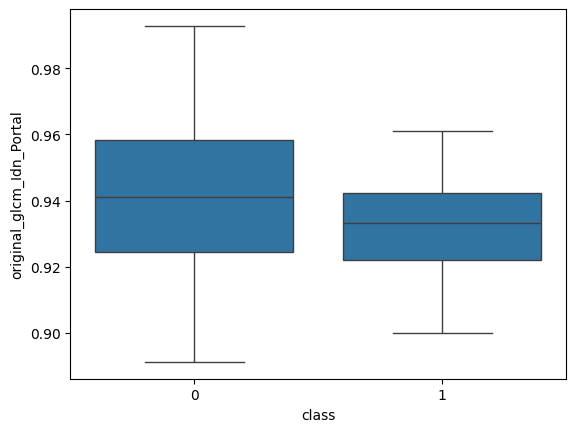

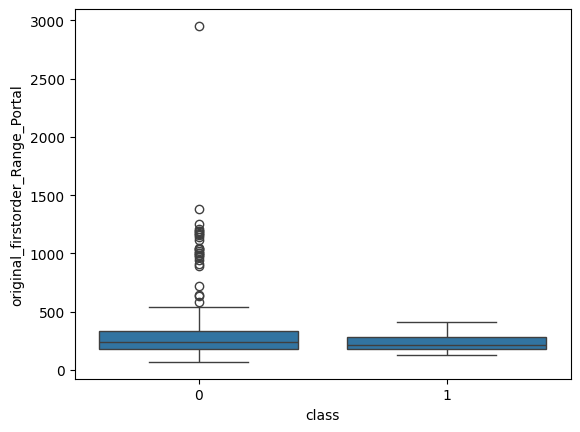

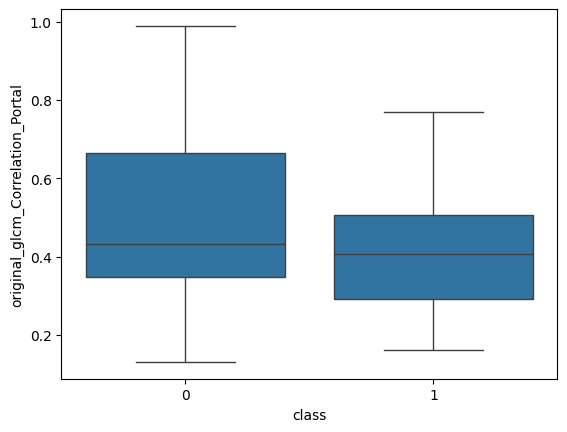

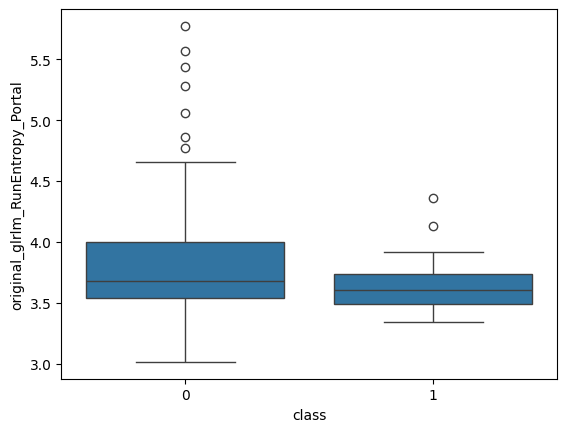

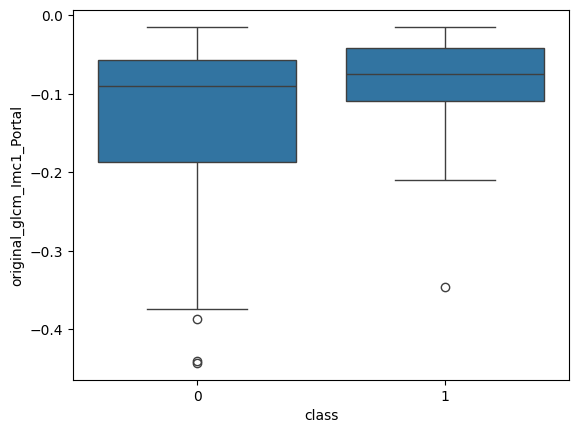

In [28]:
import seaborn as sbn # plotting library
import matplotlib.pyplot as plt

top_n = 5

ttest_results_sorted = sorted(ttest_results.keys(), key=lambda k: -ttest_results[k] ** 2)

for key in ttest_results_sorted[:top_n]:
    sbn.boxplot(x="class", y=key, data=train_radiomics_df)
    plt.show()

We now do the same for the clinical features. Clearly we see there are more radiomics features which are associated with the target variable - this could be a good indication!

In [29]:
ttest_results_sorted = sorted(ttest_results_clinical.keys(), key=lambda k: -ttest_results_clinical[k] ** 2)

for key in ttest_results_sorted[:top_n]:
    sbn.boxplot(x="class", y=key, data=train_clinical_df)
    plt.show()

## Building our model

Here we will define a pipeline (`Pipeline`) containing a set of components which we have previously discussed are aluded to:

- `VarianceThreshold` will (mostly) remove constant features
- `SelectPercentile` will be selecting the top 10% of features which are the most impactful for prediction according to an ANOVA
- `StandardScaler` will scale the data such that each feature has $\mu=0$ and $\sigma=1$
- `RFECV` will perform recursive feature elimination (i.e. features are dropped whenever they are not sufficiently important for prediction)
- `RandomForestClassifier` will be our random forest classifier

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, VarianceThreshold, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

pipeline = Pipeline(
    [("variance_threshold", VarianceThreshold()),
     ("scaler", StandardScaler()),
     # ("ufs", SelectKBest(k=100, score_func=f_classif)),
     # ("rfe", RFE(estimator=RandomForestClassifier())),
     ("model", RandomForestClassifier(
         class_weight="balanced_subsample", random_state=42))]
)

To select the best features for `SGDClassifier`, we will wrap everything in a nested cross-validation.

In [31]:
train_radiomics_df.shape

(182, 220)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from scipy.stats import uniform, randint

curr_df = train_radiomics_df
X = curr_df.drop("class", axis=1).astype(np.float32).to_numpy()
y = curr_df["class"].to_numpy()

params = {
    "model__n_estimators": randint(5, 50),
    "model__max_depth": randint(5, 20)}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

inner_model = RandomizedSearchCV(pipeline, params, cv=inner_cv, n_iter=50)
nested_score = cross_validate(
    inner_model, 
    X=X, 
    y=y, 
    cv=outer_cv, 
    scoring="roc_auc", 
    verbose=4, 
    n_jobs=5)

average_auc = np.mean(nested_score["test_score"])
print(average_auc)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END ......................................., score=0.599 total time=   9.7s
[CV] END ......................................., score=0.575 total time=   9.7s
[CV] END ......................................., score=0.746 total time=   9.7s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.6s


[CV] END ......................................., score=0.573 total time=  13.1s
[CV] END ......................................., score=0.634 total time=  14.0s
0.6254720853858785


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   14.0s finished
